# Exploring DBSCAN

## Importing Libraries


In [1]:
import pandas as pd                         # data manipulation
import numpy as np                          # numerical operations
import matplotlib.pyplot as plt             # basic plotting
import seaborn as sns                       # statistical vizualisation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import dbscan
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_score

## Crescent Moons

We will start our exploration with the classic example of the crescent-moon-shaped clusters.

In [2]:
# Generate crescent moons dataset
blobs = make_moons(500, noise=0.055, random_state=53)[0]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
# This is mostly for practice here since the scale should be uniform
blobs_scaled = scaler.fit_transform(blobs)

### Apply *k*-Means and DBSCAN

Silhouette Score (Excluding Noise): 0.38954263966705843
Silhouette Score (Including Noise): 0.38954263966705843


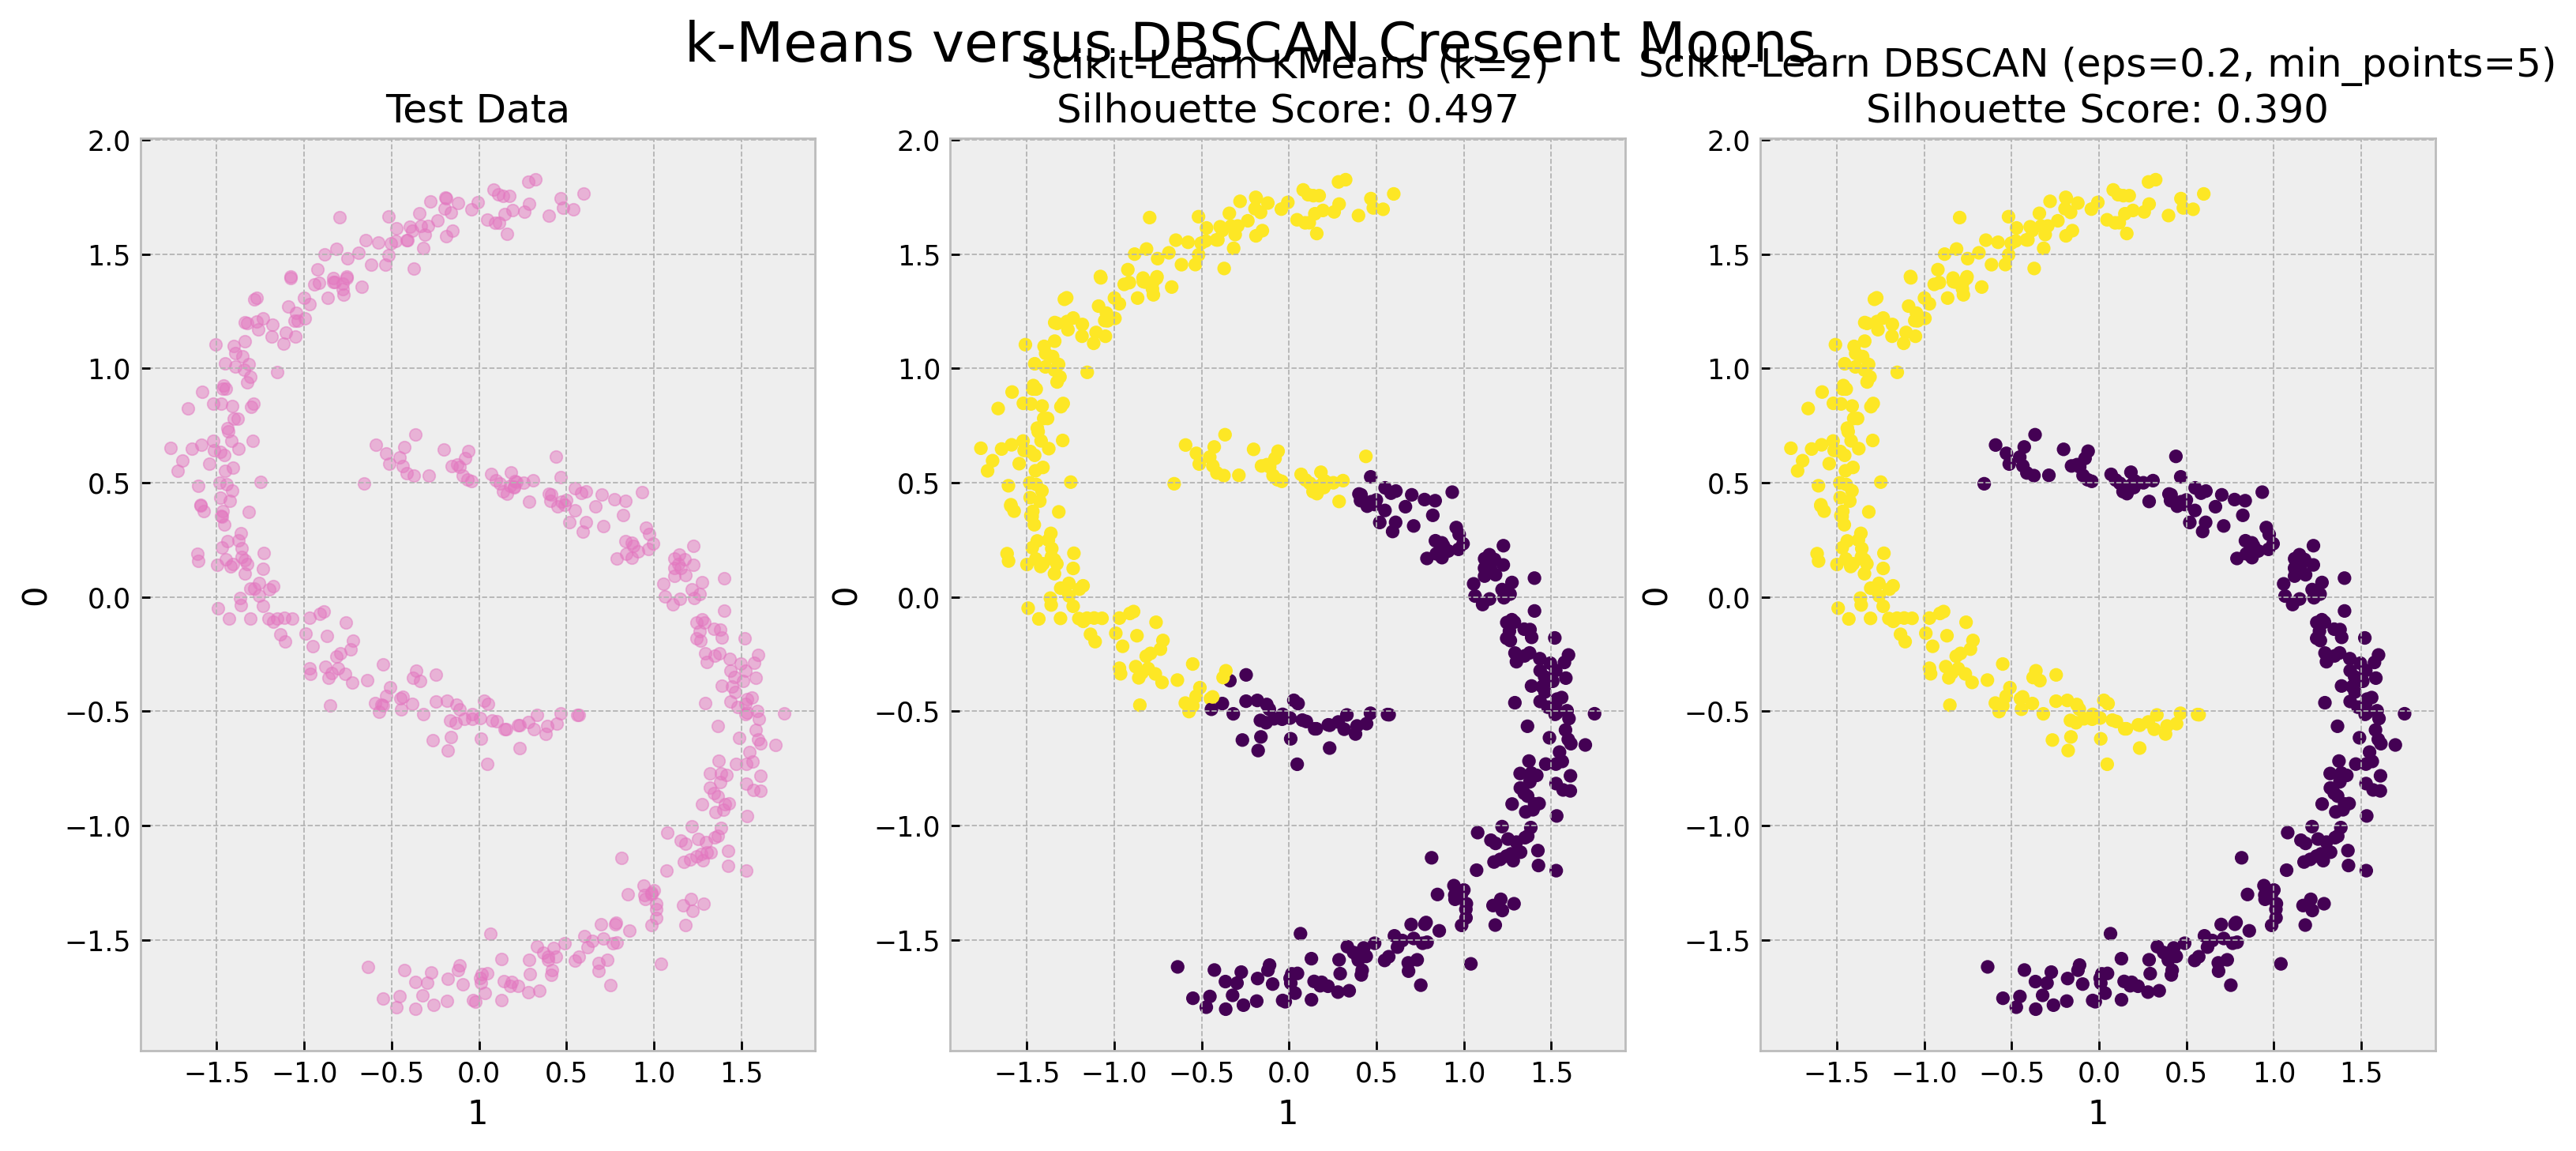

In [3]:
# Use random module to set the state of DBSCAN since it doesn't have a built-in
# random state parameter like k-means does
import random

random.seed(53)

#Plot
plt.style.use("bmh")
fig, ax = plt.subplots(1,3, dpi=250)
fig.suptitle("k-Means versus DBSCAN Crescent Moons", fontsize=20)

# Scikit-Learn KMeans
# Setting k=2
preds_k = KMeans(2, random_state=53).fit(blobs_scaled).labels_
kmean_blob = np.append(blobs_scaled, preds_k.reshape(-1,1), axis=1)
pd.DataFrame(kmean_blob).plot(x=1, y=0, kind="scatter",ax=ax[1], c=2, colorbar=False, title= "Scikit-Learn KMeans (k=2)", marker="o", colormap="viridis")

# Scikit-Learn DBSCAN
# Setting epsilon radius to 0.2 and minimum samples to 5
preds = dbscan(blobs_scaled, eps=0.2, min_samples=5)[1]
dbscan_blob = np.append(blobs_scaled, preds.reshape(-1,1), axis=1)
pd.DataFrame(dbscan_blob).plot(x=1, y=0, kind="scatter", c=2, colorbar=False, ax=ax[2], title= "Scikit-Learn DBSCAN (eps=0.2, min_points=5)", marker="o", colormap="viridis")

# Calculate silhouette score for KMeans
kmeans_silhouette = silhouette_score(blobs_scaled, preds_k)

# Calculate silhouette score for DBSCAN
# (Only include points assigned to clusters, not noise points)
dbscan_silhouette_no_noise = silhouette_score(blobs_scaled[preds != -1], preds[preds != -1])

# Silhouette score including noise
if len(set(preds)) > 1:  # Ensure more than one cluster exists
    dbscan_silhouette_noise = silhouette_score(blobs_scaled, preds)
else:
    dbscan_silhouette_noise = -1  # Assign -1 if only one cluster exists

print(f"Silhouette Score (Excluding Noise): {dbscan_silhouette_no_noise}")
print(f"Silhouette Score (Including Noise): {dbscan_silhouette_noise}")

# Test Data
pd.DataFrame(blobs_scaled).plot(x=1, y=0, kind="scatter", ax=ax[0], alpha=0.5, figsize=(15,6), title="Test Data", marker="o", c="#e377c0")

# Update titles to include silhouette scores
ax[1].set_title(f"Scikit-Learn KMeans (k=2)\nSilhouette Score: {kmeans_silhouette:.3f}")
ax[2].set_title(f"Scikit-Learn DBSCAN (eps=0.2, min_points=5)\nSilhouette Score: {dbscan_silhouette_no_noise:.3f}")

plt.show()

#### Key Takeaways

1. The silhouette score for *k*-Means is higher even though it produces unituitive (i.e., worse) clusters.
2. Silhouette score alone may not be useful
3. Interpreting Silhouette Scores With vs. Without Noise in DBSCAN:

Silhouette Score Excluding Noise (preds != -1)
- Measures the quality of clustering for only the points assigned to clusters.
- Higher score may be misleading if too many points are classified as noise.
- Useful when comparing DBSCAN to clustering methods that don’t produce noise (e.g., K-Means).
- Best for evaluating cluster cohesion and separation without penalizing for noise classification.

Silhouette Score Including Noise
- Accounts for how DBSCAN handles noise points, making it a more holistic evaluation.
- Lower scores indicate poor clustering OR excessive noise classification.
- Useful when assessing DBSCAN’s overall performance, including its ability to distinguish between clusters and noise.
- Best for identifying if DBSCAN is too aggressive in marking points as noise.

When to Use Each?
- Use excluding-noise score when evaluating the quality of formed clusters.
- Use including-noise score when assessing how well DBSCAN balances clustering and noise classification.
- Compare both to determine if high cluster quality comes at the cost of excessive noise.

### Exploring the Effect of ε (epsilon)

When features are standardized (mean = 0, std = 1):
- ε ≈ 0.5 often works as a starting point.
- Increase ε if clusters are spread out.
- Decrease ε if clusters should remain compact.

Let's rexamine with each noise point clearly marked with a red X.

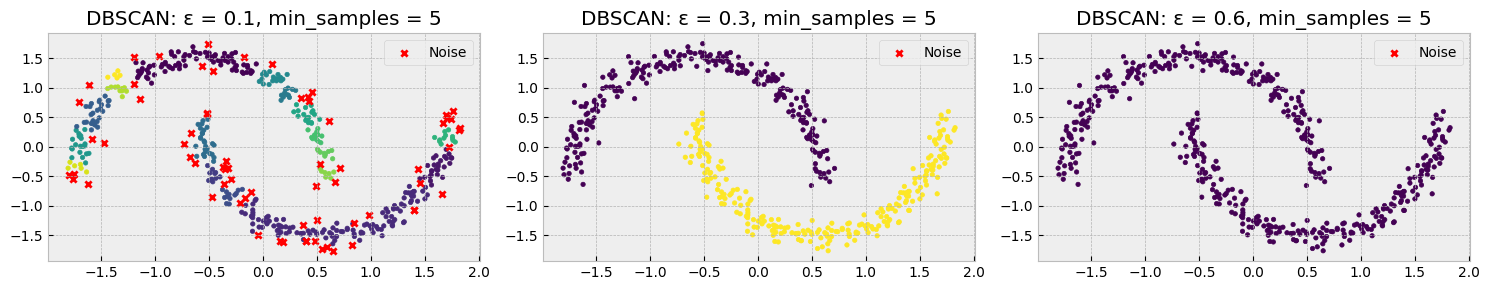

In [4]:
# Explore different epsilon values with a fixed min_samples
epsilon_values = [0.1, 0.3, 0.6]
min_samples = 5

plt.figure(figsize=(15, 3))
for i, eps in enumerate(epsilon_values):
    labels = dbscan(blobs_scaled, eps=eps, min_samples=min_samples)[1]

    plt.subplot(1, 3, i + 1)
    core_samples_mask = labels != -1  # Core and border points
    noise_mask = labels == -1         # Noise points

    # Plot core and border points normally
    plt.scatter(blobs_scaled[core_samples_mask, 0], blobs_scaled[core_samples_mask, 1],
                c=labels[core_samples_mask], cmap='viridis', s=10)

    # Plot noise as 'X' markers
    plt.scatter(blobs_scaled[noise_mask, 0], blobs_scaled[noise_mask, 1],
                c='red', marker='x', s=20, label="Noise")

    plt.title(f"DBSCAN: ε = {eps}, min_samples = {min_samples}")
    plt.legend()

plt.tight_layout()
plt.show()

### Analysis:

What happened?

We can now clearly see that there is a lot of noise with the epsilon radius set low. Why is this?

1. **ε = 0.1:** Clusters are fragmented with many noise points.  
2. **ε = 0.3:** Ideal for this dataset, accurately captures the crescent shapes.  
3. **ε = 0.6:** Clusters merge into a single cluster.

**Key Insight:**  
- **Increasing ε** increases the neighborhood size and may merge clusters.  
- **Decreasing ε** creates fragmented clusters with more noise.

### Exploring the Effect of min_samples

Let's rexamine with each noise point clearly marked with a red X.

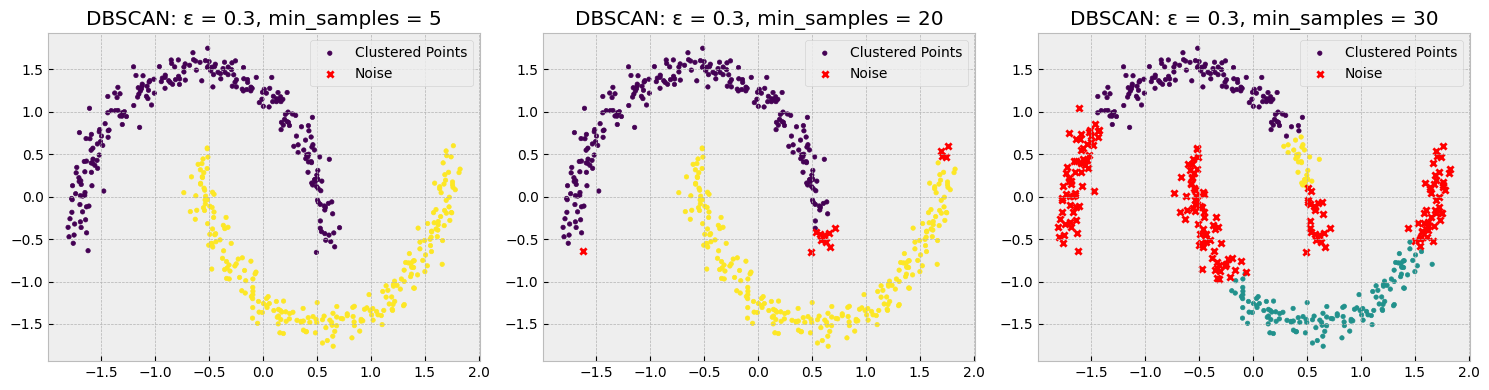

In [5]:
# Explore different min_samples values with a fixed epsilon
eps = 0.3
min_samples_values = [5, 20, 30]

plt.figure(figsize=(15, 4))

for i, ms in enumerate(min_samples_values):
    # Run DBSCAN with fixed eps and varying min_samples
    labels = dbscan(blobs_scaled, eps=eps, min_samples=ms)[1]

    plt.subplot(1, 3, i + 1)

    # NumPy Boolean masking:
    # labels != -1 creates a Boolean array where:
    #   - True  → Core and border points (part of a cluster)
    #   - False → Noise points (-1 label)
    core_samples_mask = labels != -1

    # labels == -1 creates a Boolean array where:
    #   - True  → Noise points (-1 label)
    #   - False → Clustered points (assigned a cluster label)
    noise_mask = labels == -1

    # Plot core and border points (normal clustered points)
    # blobs_scaled[core_samples_mask, 0] selects x-coordinates of cluster points
    # blobs_scaled[core_samples_mask, 1] selects y-coordinates of cluster points
    plt.scatter(blobs_scaled[core_samples_mask, 0], blobs_scaled[core_samples_mask, 1],
                c=labels[core_samples_mask], cmap='viridis', s=10,
                label="Clustered Points")  # Use the same colors as labels

    # Plot noise points separately in red with 'X' markers
    plt.scatter(blobs_scaled[noise_mask, 0], blobs_scaled[noise_mask, 1],
                c='red', marker='x', s=20, label="Noise")

    plt.title(f"DBSCAN: ε = {eps}, min_samples = {ms}")
    plt.legend()

plt.tight_layout()
plt.show()

### Analysis:

Again, we can clearly see that there are noise points in the 20 minimum samples and many noise points in the 30 minimum samples.

What happened?

1. **min_samples = 5:**
2. **min_samples = 20:**
3. **min_samples = 30:**

**Key Insight:**  
- **Increasing min_samples** requires denser regions to form clusters.  
- **Decreasing min_samples** allows more points to be considered core points, increasing noise.

## Loading Our Data

Let's explore some real-world data from San Francisco with tree data from city streets.

In [8]:
# mount Google Drive
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Specify the folder you want to access
project_folder = "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive


In [9]:
file_path = os.path.join(project_folder, "Street_Tree_List_20250107.csv")

trees_df = pd.read_csv(file_path)

In [10]:
# Display the first few rows
trees_df.head()

TreeID    qLegalStatus                                        qSpecies  \
0  225873  DPW Maintained    Koelreuteria bipinnata :: Chinese Flame Tree   
1  133842  DPW Maintained  Platanus x hispanica :: Sycamore: London Plane   
2    3119  DPW Maintained  Platanus x hispanica :: Sycamore: London Plane   
3    3120  DPW Maintained  Platanus x hispanica :: Sycamore: London Plane   
4  272733  DPW Maintained     Fraxinus uhdei :: Shamel Ash: Evergreen Ash   

             qAddress  SiteOrder                     qSiteInfo PlantType  \
0      822 Alabama St        1.0  Sidewalk: Curb side : Cutout      Tree   
1  3170 California St        1.0  Sidewalk: Curb side : Cutout      Tree   
2  3170 California St        3.0  Sidewalk: Curb side : Cutout      Tree   
3  3170 California St        4.0  Sidewalk: Curb side : Cutout      Tree   
4     590 Masonic Ave        4.0  Sidewalk: Curb side : Cutout      Tree   

  qCaretaker qCareAssistant PlantDate  ...        YCoord   Latitude  \
0    Private            NaN       NaN  ...  2.104279e+06  37.758462   
1    Private            NaN       NaN  ...  2.115022e+06  37.787404   
2    Private            NaN       NaN  ...  2.115015e+06  37.787381   
3    Private            NaN       NaN  ...  2.115012e+06  37.787374   
4    Private            NaN       NaN  ...  2.110904e+06  37.776091   

    Longitude                                   Location  \
0 -122.411593   (37.75846190721876, -122.41159276561366)   
1 -122.446379  (37.787403655494266, -122.44637901807063)   
2 -122.446532  (37.787380880159084, -122.44653244062533)   
3 -122.446592   (37.787373511112456, -122.4465917751871)   
4 -122.446402   (37.77609111946836, -122.44640232649878)   

   Fire Prevention Districts  Police Districts  Supervisor Districts  \
0                        2.0               4.0                   7.0   
1                       13.0               6.0                   1.0   
2                       13.0               6.0                   1.0   
3                       13.0               6.0                   1.0   
4                       15.0               5.0                  11.0   

  Zip Codes  Neighborhoods (old)  Analysis Neighborhoods  
0   28859.0                 19.0                    20.0  
1   29490.0                 31.0                    31.0  
2   29490.0                 31.0                    31.0  
3   29490.0                 31.0                    31.0  
4   29492.0                 16.0                    18.0  

[5 rows x 24 columns]

Explanation:
- We focus on columns related to species and location.
- Latitude and Longitude need cleaning before clustering.

### Clean Latitude and Longitude Data

Issues Identified:
- Missing values in Latitude and Longitude.
- Location column stores coordinates as a string like:

"(37.75846190721876, -122.41159276561366)"

Solution:
- Fill missing Latitude/Longitude by parsing the Location string.
- Remove invalid rows.

In [11]:
import re

# Function to extract latitude and longitude from Location string
def extract_lat_lon(location_str):
    try:
        # Match pattern: (lat, lon)
        match = re.match(r"\(([-\d.]+), ([-\d.]+)\)", str(location_str))
        if match:
            return float(match.group(1)), float(match.group(2))
    except (ValueError, TypeError):
        pass
    return None, None

# Apply extraction and fill missing lat/lon values
lat_lon_data = trees_df.apply(
    lambda row: extract_lat_lon(row['Location']) if pd.isna(row['Latitude']) or pd.isna(row['Longitude']) else (row['Latitude'], row['Longitude']),
    axis=1
)

# Convert the resulting Series of tuples into two columns
trees_df['Latitude'], trees_df['Longitude'] = zip(*lat_lon_data)

# Remove rows with missing or invalid coordinates
trees_clean = trees_df.dropna(subset=['Latitude', 'Longitude'])
trees_clean = trees_clean[(trees_clean['Latitude'].between(37.5, 37.9)) &
                          (trees_clean['Longitude'].between(-123, -122))]

# Verify the cleaned data
trees_clean[['Latitude', 'Longitude']].describe()

Latitude      Longitude
count  195264.000000  195264.000000
mean       37.759624    -122.434645
std         0.024248       0.029905
min        37.509004    -122.511257
25%        37.740116    -122.454129
50%        37.760144    -122.431293
75%        37.779567    -122.412801
max        37.819928    -122.366622

What'd we do?

- We filtered out rows with coordinates far outside SF's range.

### Visualize Tree Locations

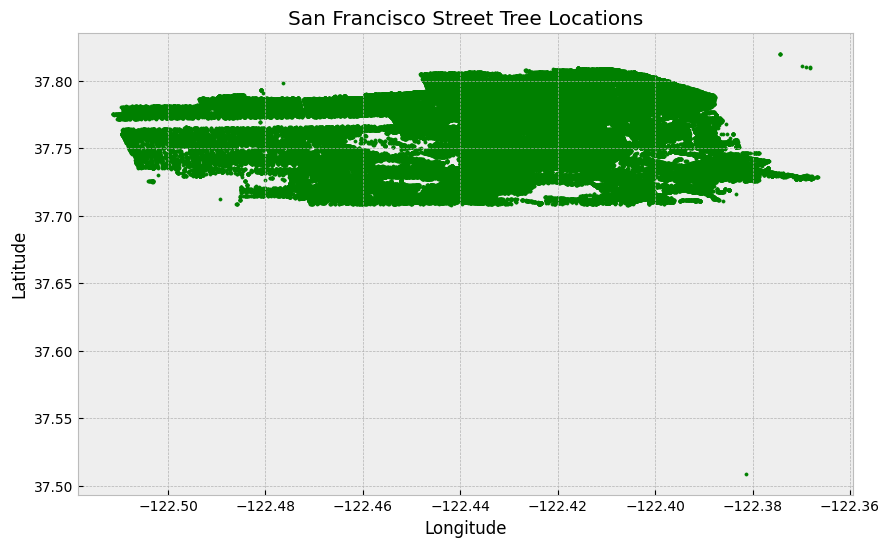

In [12]:
# Plot tree locations
plt.figure(figsize=(10, 6))
plt.scatter(trees_clean['Longitude'], trees_clean['Latitude'], s=5, color='green')
plt.title('San Francisco Street Tree Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We've got a figure dimension issue...

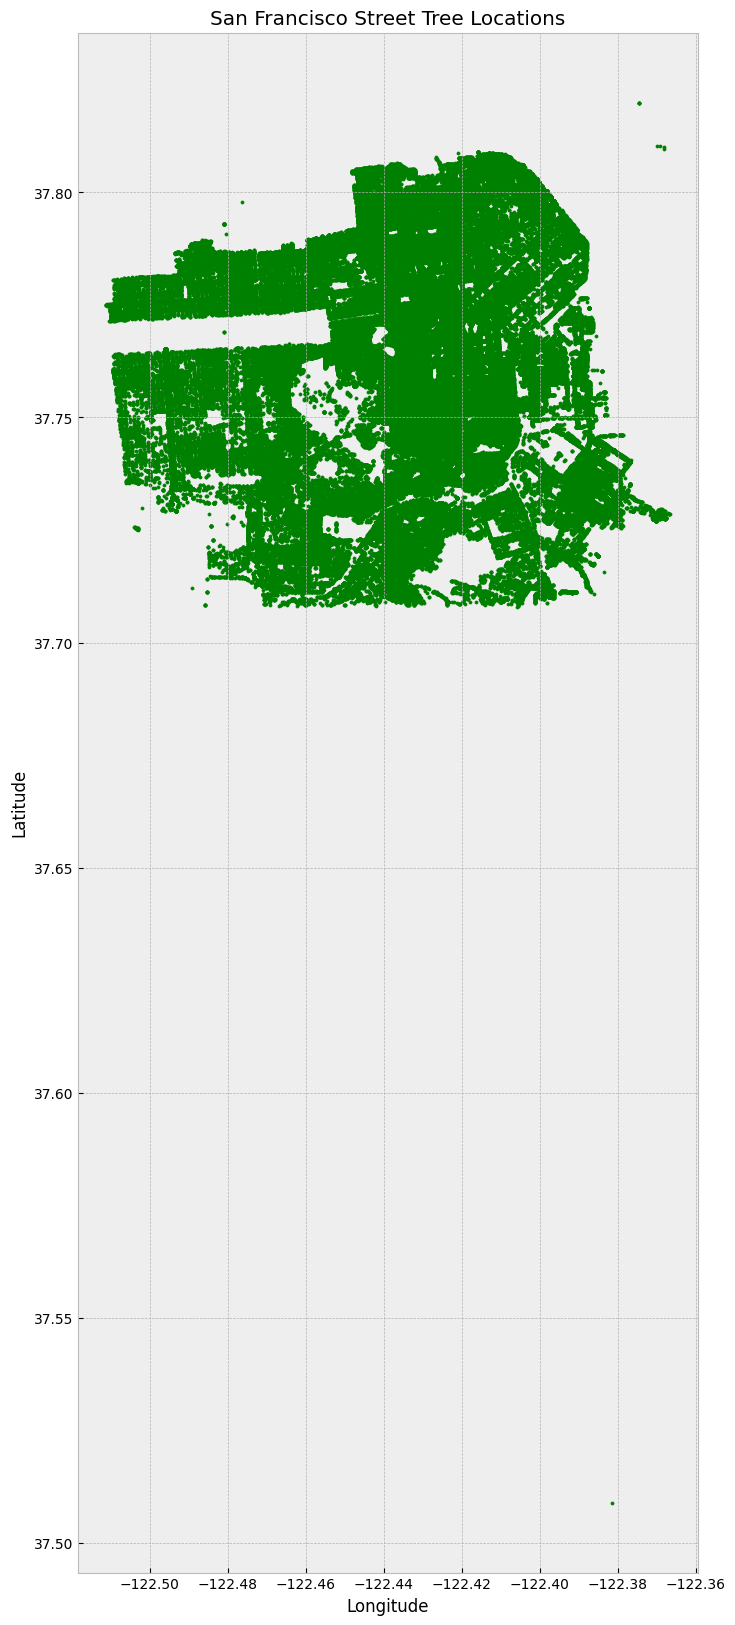

In [13]:
# Plot tree locations
plt.figure(figsize=(8,20))
plt.scatter(trees_clean['Longitude'], trees_clean['Latitude'], s=5, color='green')
plt.title('San Francisco Street Tree Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Apply *k*-Means

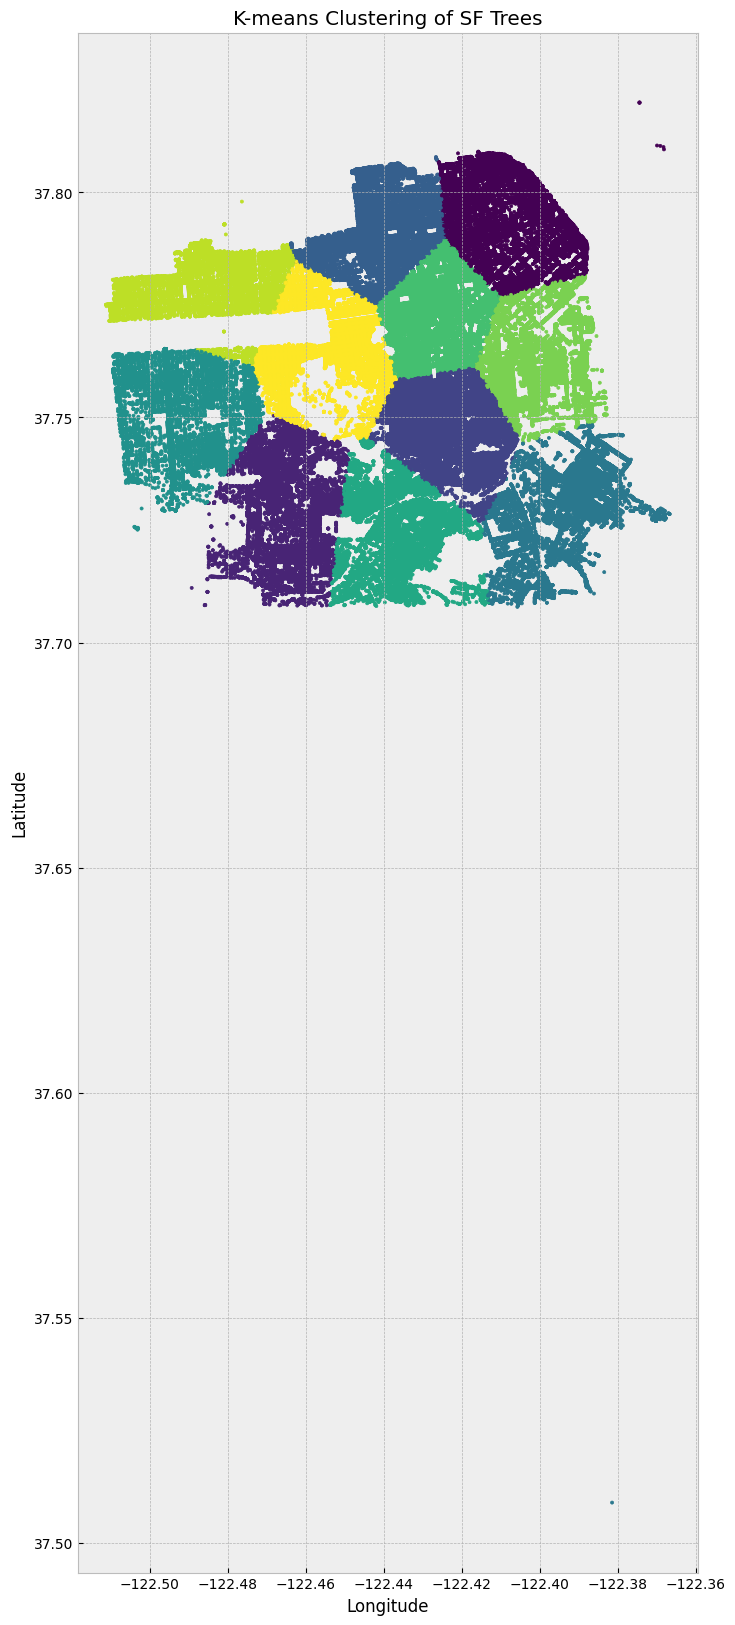

In [14]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=11, random_state=42)
trees_clean['kmeans_cluster'] = kmeans.fit_predict(trees_clean[['Longitude', 'Latitude']])

# Plot K-means clusters
plt.figure(figsize=(8, 20))
plt.scatter(trees_clean['Longitude'], trees_clean['Latitude'], c=trees_clean['kmeans_cluster'], cmap='viridis', s=5)
plt.title('K-means Clustering of SF Trees')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### Apply DBSCAN

First, we will show progressively smaller epsilon values and how the decreasing radius impacts the number of clusters and noise.

Next, we will show progressively larger min_samples and how the increasing density threshold impacts the number of clusters and noise.

#### Varying Epsilon

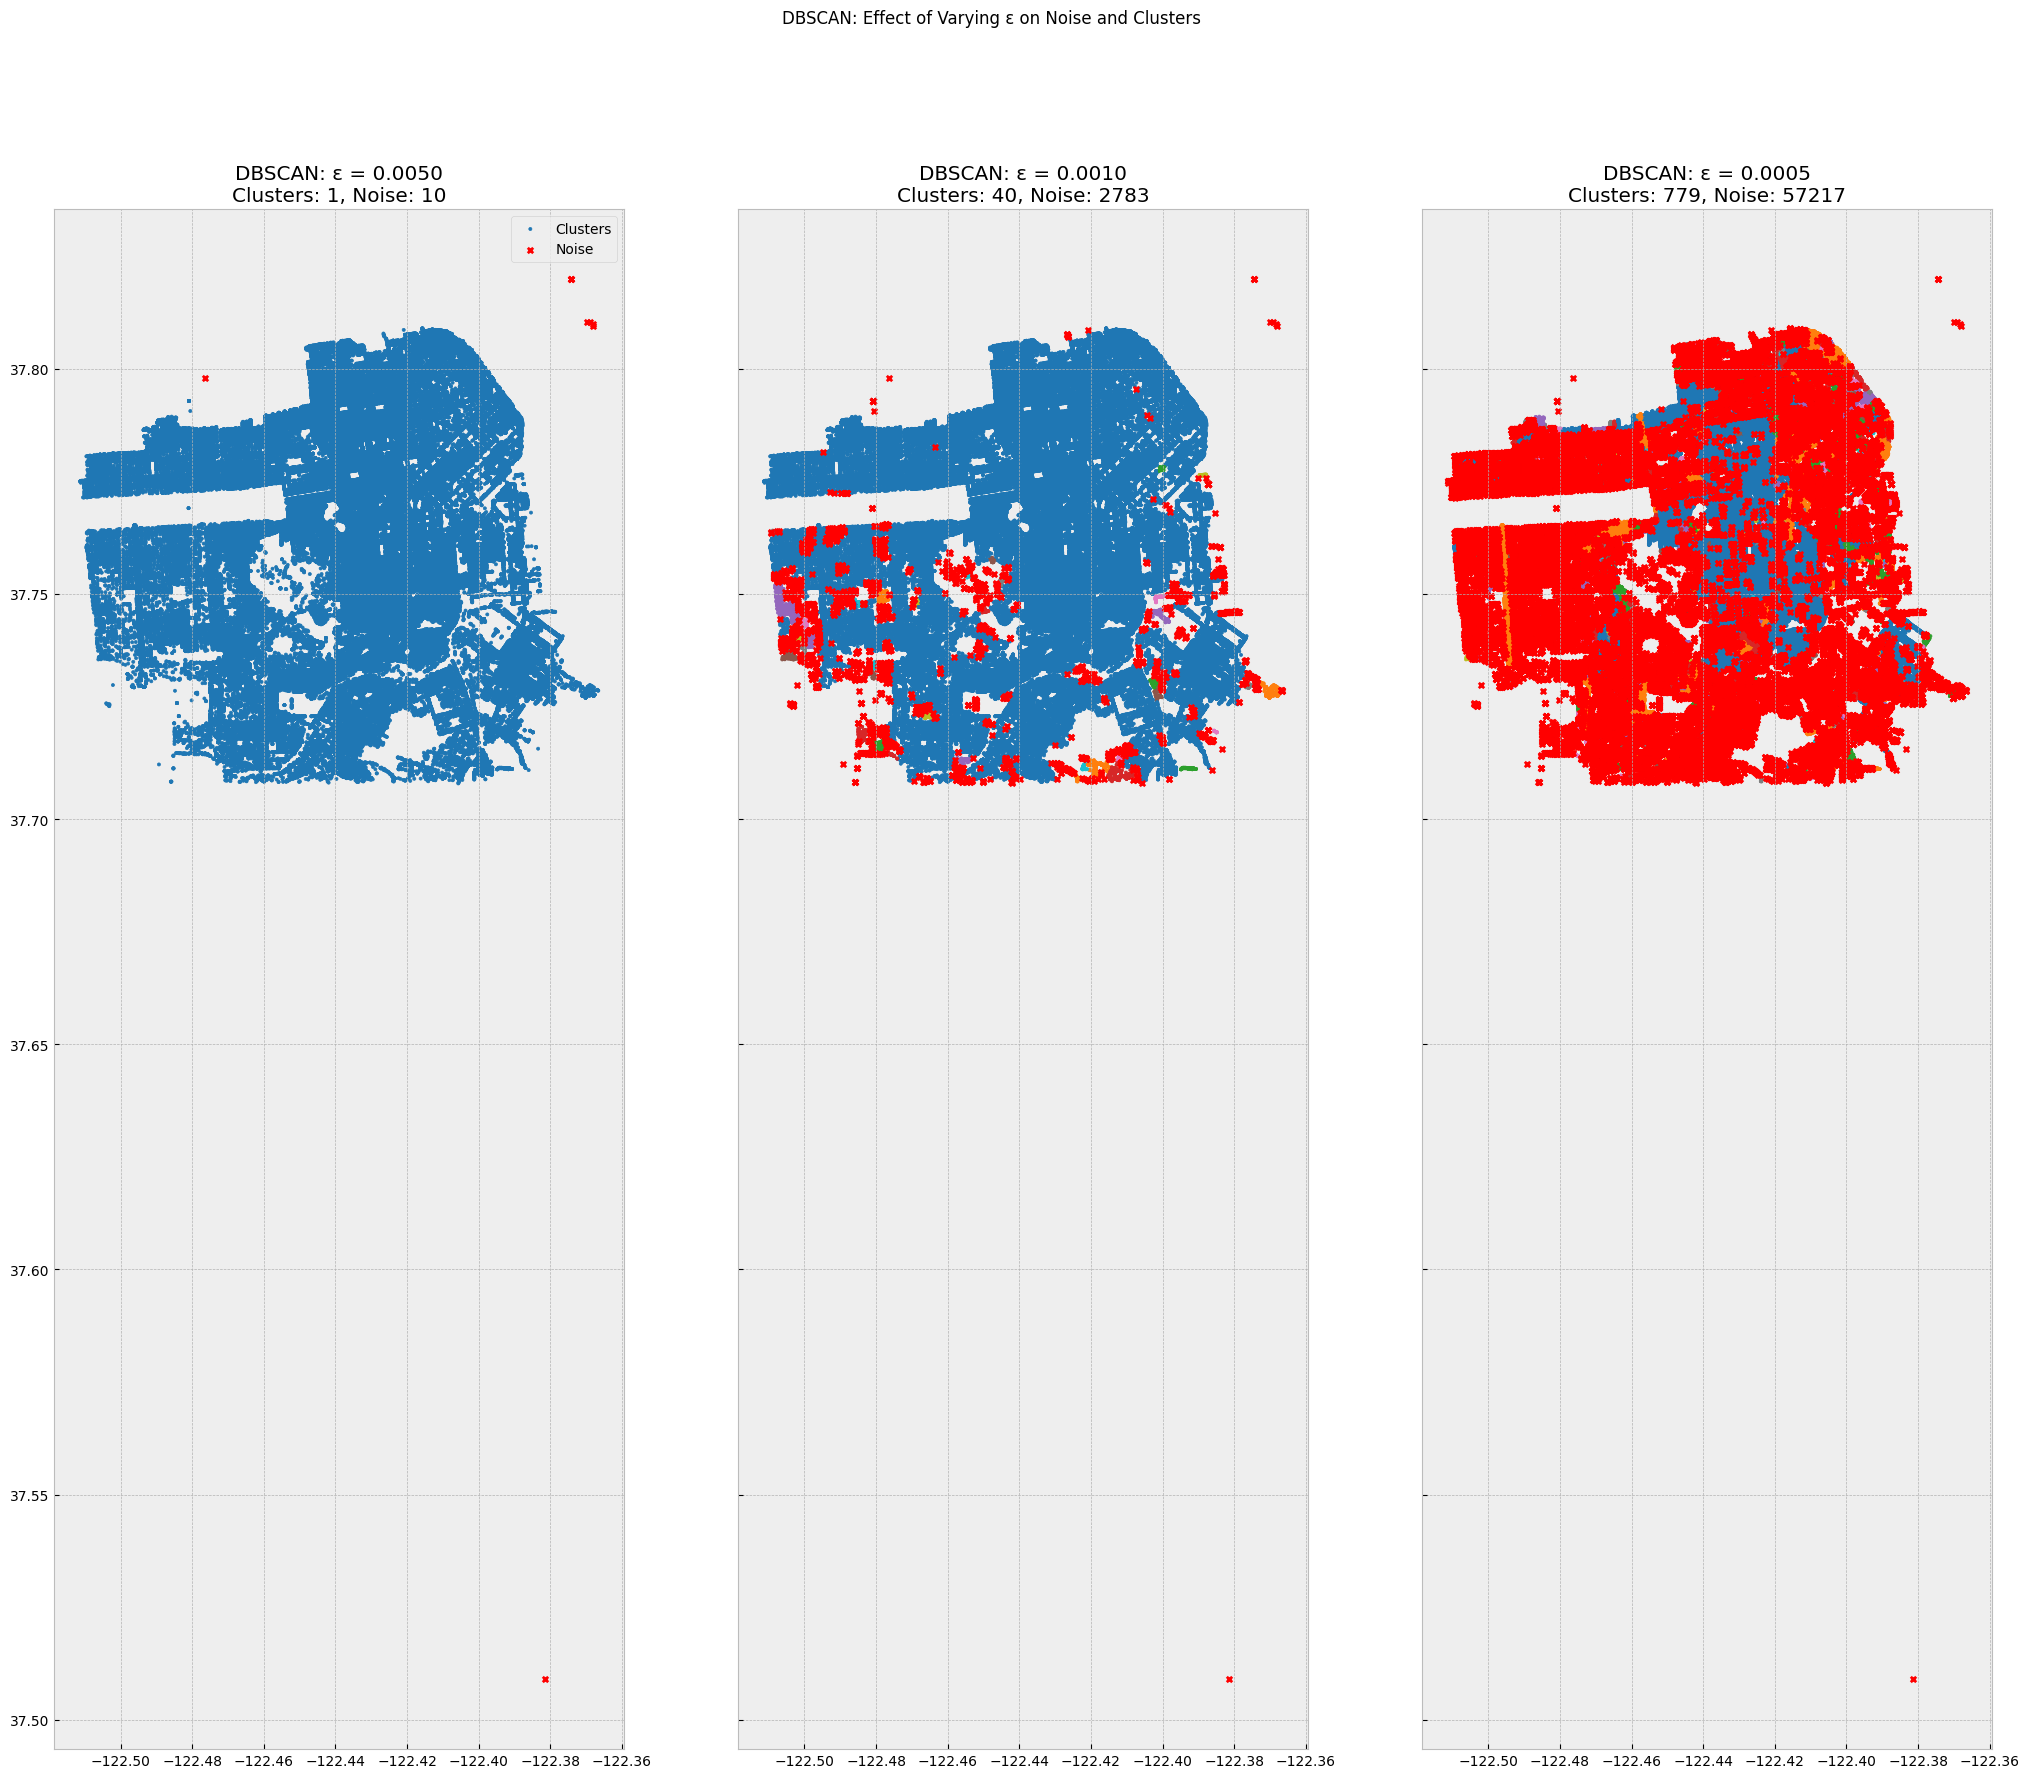

In [15]:

# Define progressively smaller epsilon values
epsilon_values = [0.005, 0.001, 0.0005]  # Decreasing ε
min_samples = 30

# Prepare subplots
fig, axes = plt.subplots(1, len(epsilon_values), figsize=(25, 20), sharex=True, sharey=True)

for i, eps in enumerate(epsilon_values):
    # Apply DBSCAN clustering
    clusters = dbscan(X=trees_clean[['Longitude', 'Latitude']], eps=eps, min_samples=min_samples)
    labels = clusters[1]  # Extract cluster labels

    # Identify noise points (labeled as -1) and clusters
    noise_mask = labels == -1
    cluster_mask = labels != -1

    # Count the number of unique clusters (excluding noise)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_noise = np.sum(noise_mask)

    # Plot cluster points
    scatter = axes[i].scatter(trees_clean.loc[cluster_mask, 'Longitude'],
                              trees_clean.loc[cluster_mask, 'Latitude'],
                              c=labels[cluster_mask], cmap='tab10', s=5, label='Clusters')

    # Plot noise points separately in red with "X" markers
    axes[i].scatter(trees_clean.loc[noise_mask, 'Longitude'],
                    trees_clean.loc[noise_mask, 'Latitude'],
                    c='red', marker='x', s=15, label='Noise')

    # Add title with cluster and noise count
    axes[i].set_title(f"DBSCAN: ε = {eps:.4f}\nClusters: {num_clusters}, Noise: {num_noise}")

    # Add legend to first plot only
    if i == 0:
        axes[i].legend(loc='upper right')

# Adjust layout and show the plot
plt.suptitle("DBSCAN: Effect of Varying ε on Noise and Clusters")
plt.show()


What is happening here?



#### Varying Minimum Samples

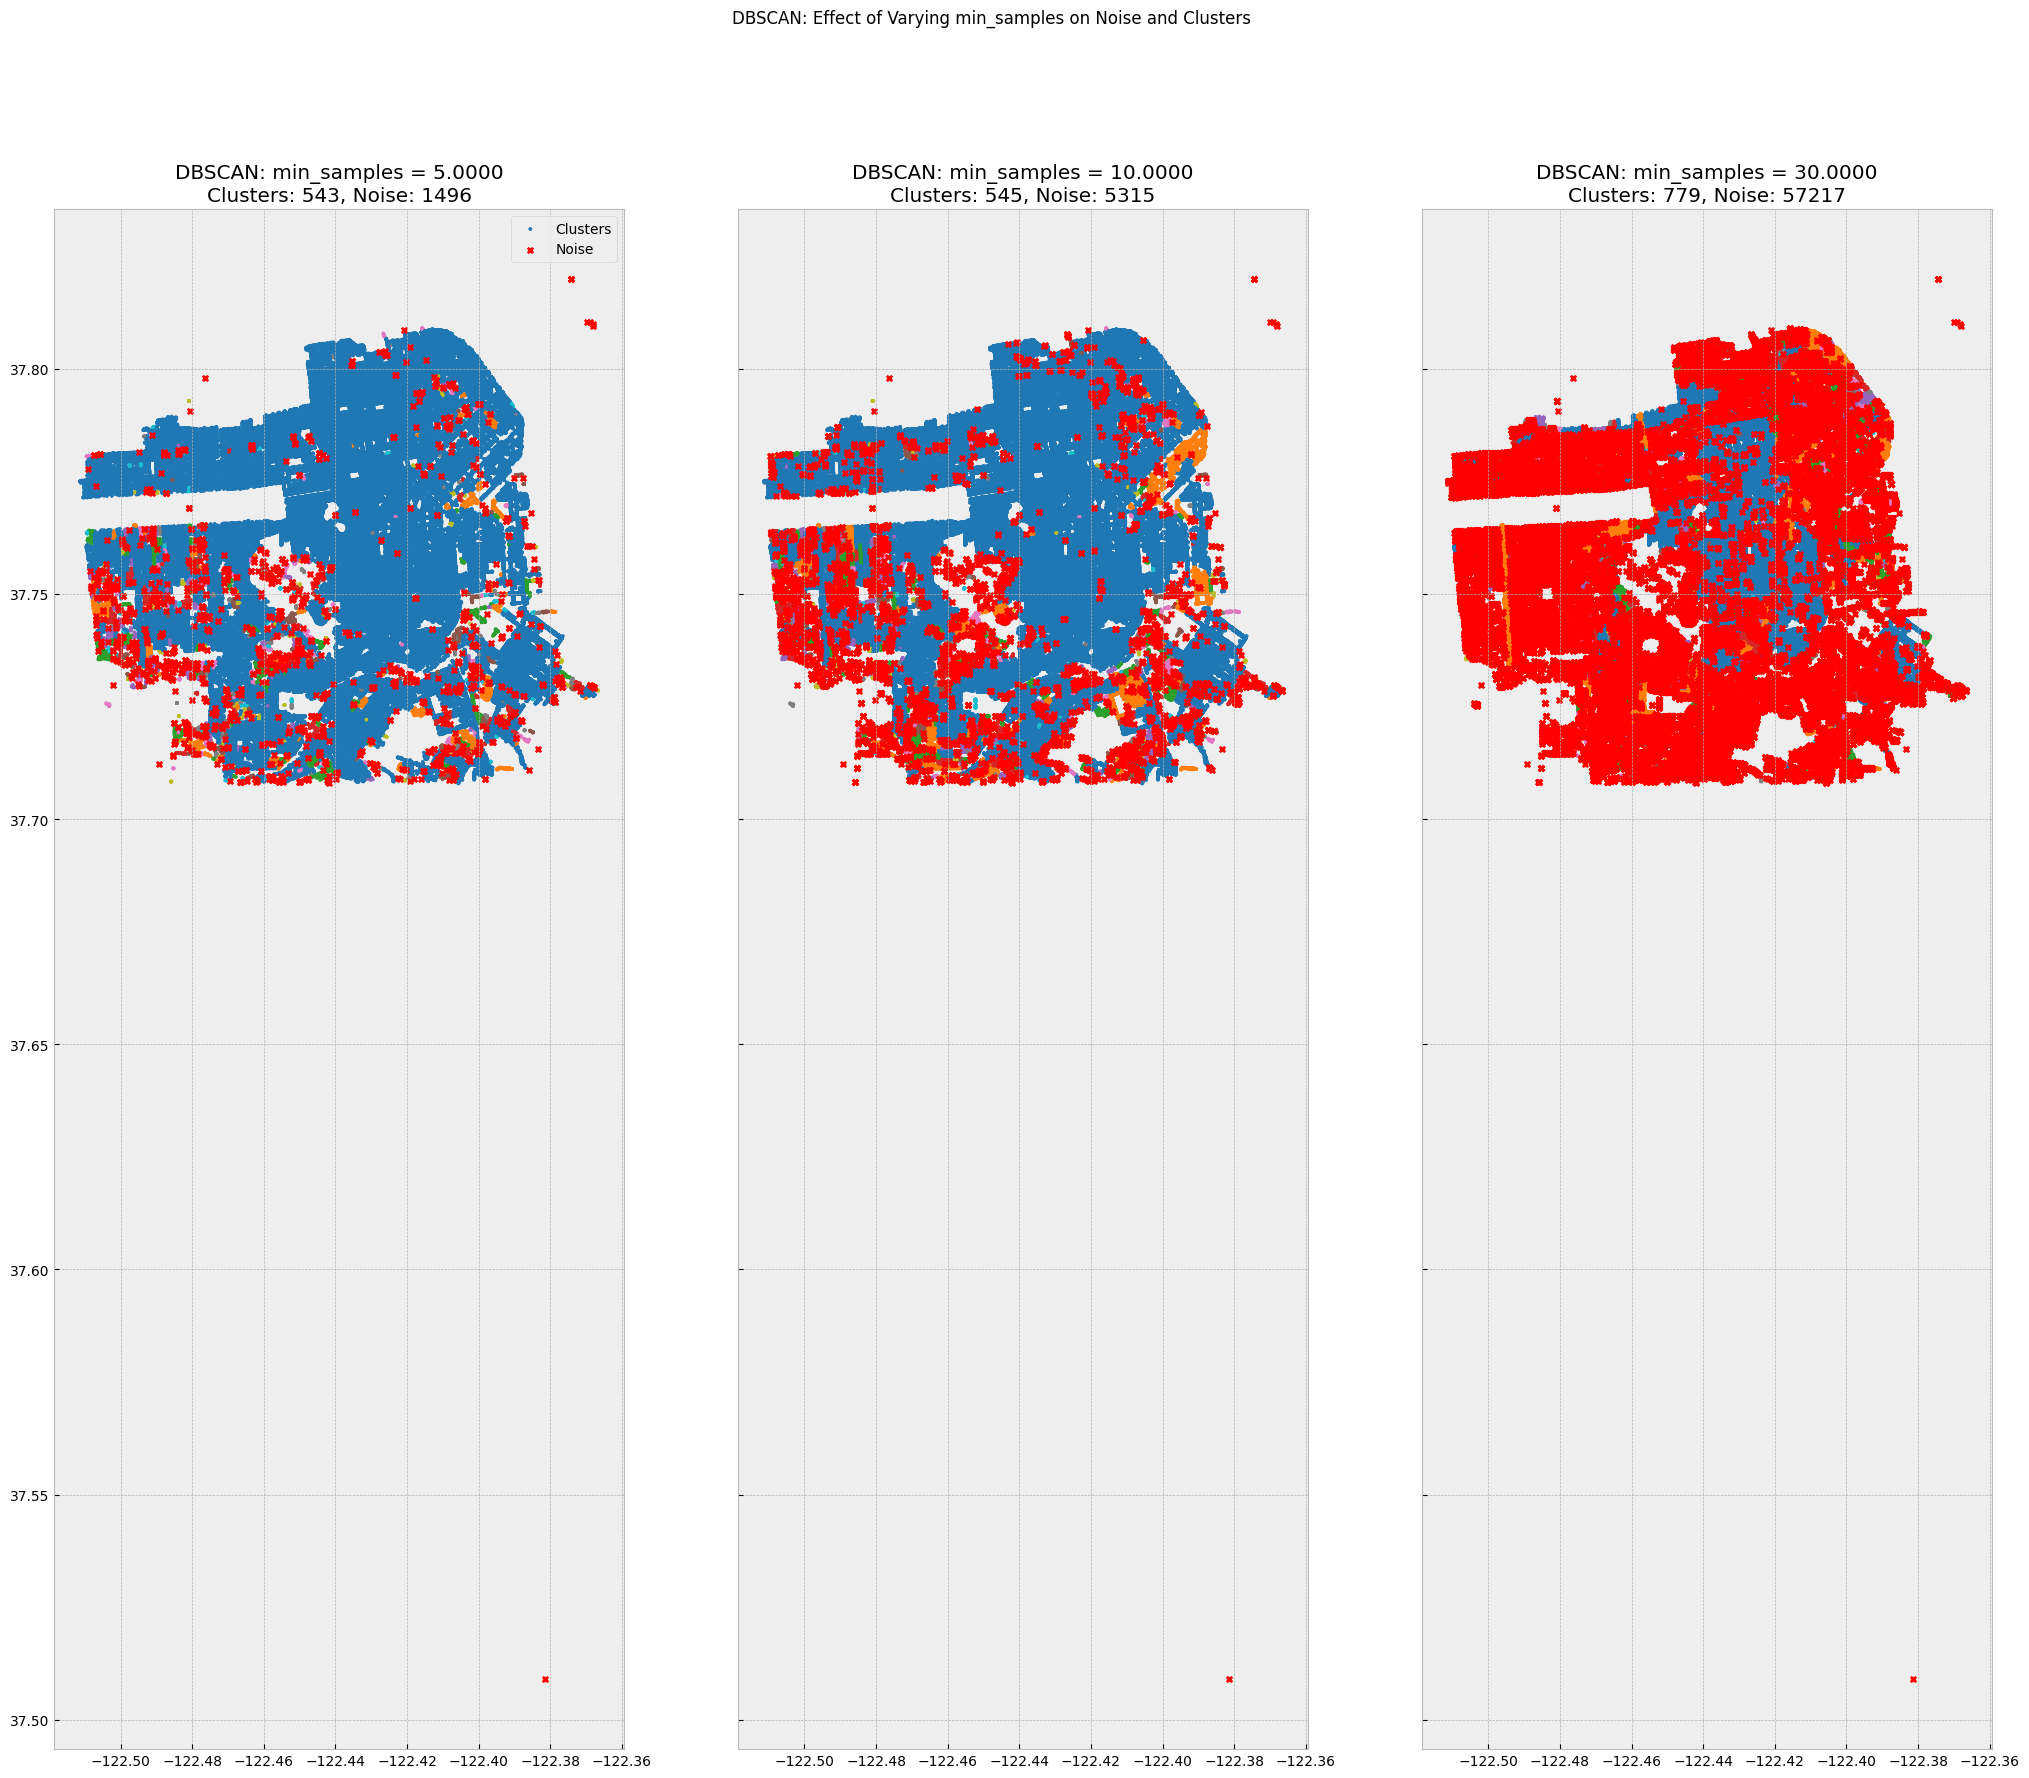

In [16]:

# Define progressively smaller epsilon values
epsilon_values = 0.005
min_samples = [5, 10, 30]

# Prepare subplots
fig, axes = plt.subplots(1, len(min_samples), figsize=(25, 20), sharex=True, sharey=True)

for i, ms in enumerate(min_samples):
    # Apply DBSCAN clustering
    clusters = dbscan(X=trees_clean[['Longitude', 'Latitude']], eps=eps, min_samples=ms)
    labels = clusters[1]  # Extract cluster labels

    # Identify noise points (labeled as -1) and clusters
    noise_mask = labels == -1
    cluster_mask = labels != -1

    # Count the number of unique clusters (excluding noise)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_noise = np.sum(noise_mask)

    # Plot cluster points
    scatter = axes[i].scatter(trees_clean.loc[cluster_mask, 'Longitude'],
                              trees_clean.loc[cluster_mask, 'Latitude'],
                              c=labels[cluster_mask], cmap='tab10', s=5, label='Clusters')

    # Plot noise points separately in red with "X" markers
    axes[i].scatter(trees_clean.loc[noise_mask, 'Longitude'],
                    trees_clean.loc[noise_mask, 'Latitude'],
                    c='red', marker='x', s=15, label='Noise')

    # Add title with cluster and noise count
    axes[i].set_title(f"DBSCAN: min_samples = {ms:.4f}\nClusters: {num_clusters}, Noise: {num_noise}")

    # Add legend to first plot only
    if i == 0:
        axes[i].legend(loc='upper right')

# Adjust layout and show the plot
plt.suptitle("DBSCAN: Effect of Varying min_samples on Noise and Clusters")
plt.show()


What is happening here?

#### Explore Different Epsilon Values

Adjust the epsilon values with a partner and observe what changes.

#### Explore Different Minimum Samples

Adjust the min_samples values with a partner and observe what changes.

What do you notice as epsilon increases?

What do you notice as min_samples increase?

Which approach *k*-Means or DBSCAN works best for this data?

K-means (with 4 clusters) appears to work better for the SF tree data for several reasons:

Natural Geographic Divisions: The k-means visualization shows clear, distinct regions that correspond well to San Francisco's actual geographic areas (roughly dividing the city into quadrants - northwest, northeast, southwest, and southeast). These divisions make intuitive sense given San Francisco's urban planning and geography.
Complete Coverage: K-means assigns every tree to a cluster, which is appropriate here since all trees are part of the urban forest system. There's no real concept of "noise" or "outlier trees" that would benefit from DBSCAN's noise identification.
Distribution Pattern: The tree data shows relatively continuous distribution across San Francisco rather than dense clusters separated by sparse areas. K-means handles this type of continuous spatial distribution better than DBSCAN, which is designed to find density-based clusters.

In contrast, based on earlier experiments in the notebook, DBSCAN would likely either:

Fragment the data into too many small clusters (with low epsilon values)
Merge everything into a single cluster (with high epsilon values)
Create arbitrary boundaries that don't reflect the natural geographic divisions of the city

While DBSCAN excelled at identifying the crescent moon shapes in the earlier example (where there were clear density-based patterns), the SF tree distribution doesn't have the same kind of natural density-based clustering structure that DBSCAN is designed to identify.

## Order of Data Can Affect Border Point Assignment

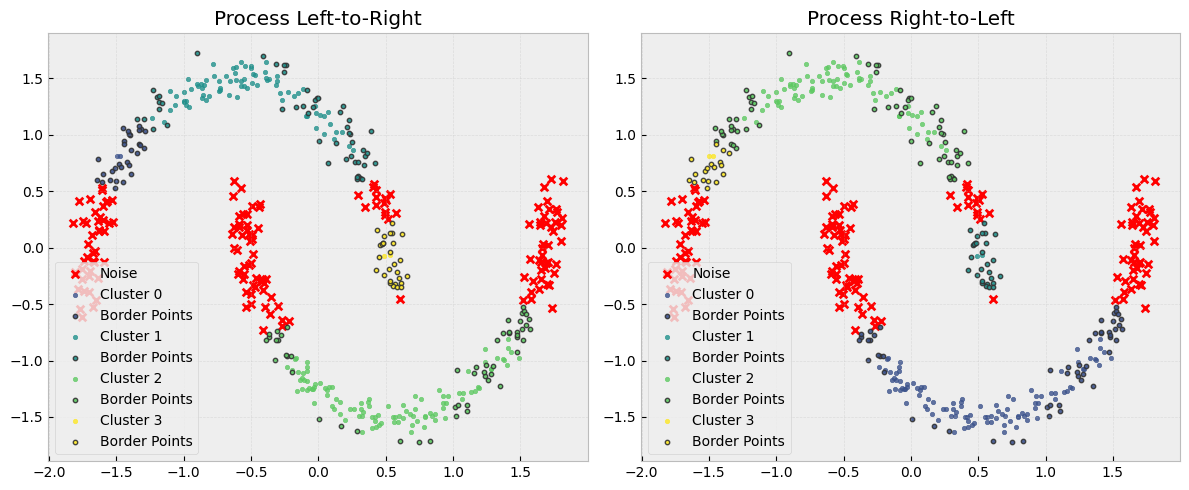

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

def generate_crescent_moons():
    """
    Generate crescent moon dataset with noise.
    """
    X, _ = make_moons(n_samples=500, noise=0.05, random_state=42)
    X = StandardScaler().fit_transform(X)  # Normalize data for better clustering
    return X

def custom_dbscan(X, eps=0.3, min_samples=30, process_order=None):
    """
    Custom DBSCAN where order of processing affects border point assignment.
    """
    n_points = X.shape[0]
    if process_order is None:
        process_order = np.arange(n_points)

    labels = np.full(n_points, -1)  # Initialize all as unassigned
    core_points = np.zeros(n_points, dtype=bool)

    # Compute neighborhoods
    nbrs = NearestNeighbors(radius=eps).fit(X)
    neighborhoods = nbrs.radius_neighbors(X, eps, return_distance=False)

    # Identify core points
    for i in range(n_points):
        if len(neighborhoods[i]) >= min_samples:
            core_points[i] = True

    # Assign clusters following process_order
    current_cluster = 0
    for idx in process_order:
        if labels[idx] != -1:  # Skip already labeled points
            continue

        if not core_points[idx]:  # Skip non-core points for now
            continue

        labels[idx] = current_cluster
        stack = [idx]

        while stack:
            current_point = stack.pop()
            neighbors = neighborhoods[current_point]

            for neighbor in neighbors:
                if labels[neighbor] == -1:
                    labels[neighbor] = current_cluster
                    if core_points[neighbor]:
                        stack.append(neighbor)

        current_cluster += 1

    return labels, ~core_points & (labels != -1)

def plot_clusters(X, labels, border_points_mask, title, ax):
    """
    Visualizes clusters and highlights border points with dark grey outlines.
    """
    unique_labels = np.unique(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Assign colors dynamically

    for i, label in enumerate(unique_labels):
        mask = labels == label
        if label == -1:
            ax.scatter(X[mask, 0], X[mask, 1], c='red',
                       marker='x', s=30, label='Noise')
        else:
            core_mask = mask & ~border_points_mask
            border_mask = mask & border_points_mask

            # Core points: Normal scatter
            ax.scatter(X[core_mask, 0], X[core_mask, 1],
                       color=colors[i], s=10, alpha=0.8, label=f'Cluster {label}')

            # Border points: Same color but outlined in dark grey
            if np.any(border_mask):
                ax.scatter(X[border_mask, 0], X[border_mask, 1],
                           facecolors=colors[i], edgecolors='#333333',
                           linewidth=1, alpha=0.9, s=10, label="Border Points")

    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

# Generate crescent moons dataset
X = generate_crescent_moons()

# Define two different processing orders
order1 = np.argsort(X[:, 0])  # Left to right
order2 = np.argsort(-X[:, 0]) # Right to left

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Process with order 1
labels1, border_points1 = custom_dbscan(X, eps=0.3, min_samples=30, process_order=order1)
plot_clusters(X, labels1, border_points1, "Process Left-to-Right", ax1)

# Process with order 2
labels2, border_points2 = custom_dbscan(X, eps=0.3, min_samples=30, process_order=order2)
plot_clusters(X, labels2, border_points2, "Process Right-to-Left", ax2)

plt.tight_layout()
plt.show()



**Key Takeaways**

1. Core, border, and noise points are all stable across processing orders.

2. Processing order only affects which cluster a border point is assigned to.
- Since border points do not form their own clusters, they are assigned to the first core point that reaches them.
- If a different cluster reaches them first (due to processing order), their cluster assignment can change, even though they remain border points.

3. Core points determine new clusters; just because border points are close doesn't mean they will belong to the same cluster.



## Grid Search

## California House Prices

In [18]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
X_housing = california.data[:, [6, 7]]  # Latitude and Longitude
y_housing = california.target  # Median house value

#### Explore the Data

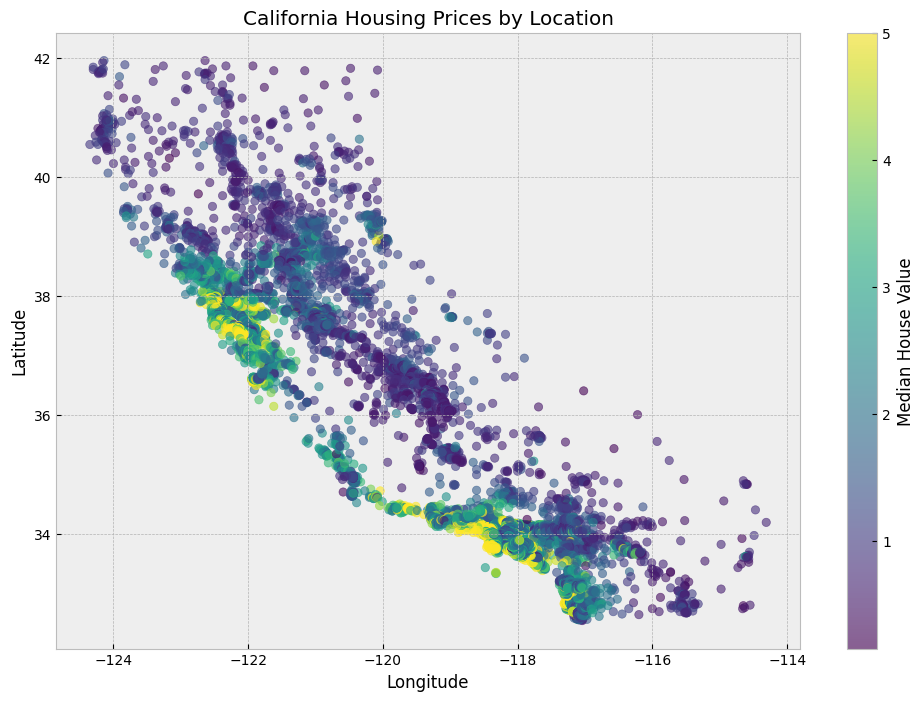

In [19]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_housing[:, 1], X_housing[:, 0],
                     c=y_housing, cmap='viridis', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California Housing Prices by Location')
plt.colorbar(scatter, label='Median House Value')
plt.show()

Observations supporting DBSCAN as appropriate choice:
1. Housing clusters follow geographic features (coastlines, valleys)
2. Varying density between urban and rural areas
3. Natural noise in housing patterns (isolated properties)
4. Arbitrary cluster shapes following population patterns
5. Number of clusters not known a priori

### Introduction to Grid Search for DBSCAN on California Housing Data

## Grid Search for DBSCAN on California Housing Prices

We will apply **DBSCAN** to **California housing price data**, using **Latitude and Longitude** as features to discover spatial clusters.

### **Steps:**
1. **Compute silhouette scores** for different `eps` and `min_samples` values.
2. **Visualize 2D clusters** for different `eps` and `min_samples` values.
3. **Extend to 3D features using PCA** (e.g., adding `MedInc` to see if income affects clusters).
4. **Compare human evaluation vs. programmatic best silhouette scores.**

#### Grid Search for Silhouette Scores

In [22]:
from sklearn.cluster import DBSCAN
# Define Grid Search Parameters
eps_values = np.linspace(0.01, 0.5, 10)  # Small to large neighborhood sizes
min_samples_values = [3, 5, 10, 20]  # Varying density thresholds

# Store results
results = []

# Grid Search: Compute Silhouette Scores
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_housing)

        # Ignore single-cluster cases to avoid silhouette score errors
        if len(set(labels)) > 1:
            score = silhouette_score(X_housing, labels)
        else:
            score = -1  # Indicates poor clustering

        results.append((eps, min_samples, score))

# # Convert results to DataFrame for better visualization
#results_df = pd.DataFrame(results, columns=["Epsilon", "Min Samples", "Silhouette Score"])

# results_df

# # Display results
#import ace_tools as tools
#tools.display_dataframe_to_user(name="DBSCAN Silhouette Score Results", dataframe=results_df)

In [23]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Epsilon", "Min Samples", "Silhouette Score"])

results_df

Epsilon  Min Samples  Silhouette Score
0   0.010000            3         -0.040985
1   0.010000            5         -0.181939
2   0.010000           10         -0.554349
3   0.010000           20         -0.731279
4   0.064444            3         -0.098987
5   0.064444            5          0.194690
6   0.064444           10          0.163285
7   0.064444           20          0.217501
8   0.118889            3         -0.143657
9   0.118889            5          0.066533
10  0.118889           10          0.108384
11  0.118889           20          0.152903
12  0.173333            3         -0.004828
13  0.173333            5          0.271462
14  0.173333           10          0.173713
15  0.173333           20          0.322622
16  0.227778            3          0.047398
17  0.227778            5          0.067261
18  0.227778           10          0.320556
19  0.227778           20          0.317923
20  0.282222            3         -0.493881
21  0.282222            5         -0.471401
22  0.282222           10         -0.296663
23  0.282222           20          0.357043
24  0.336667            3         -0.077744
25  0.336667            5         -0.038784
26  0.336667           10         -0.052667
27  0.336667           20          0.658025
28  0.391111            3         -0.116307
29  0.391111            5         -0.037547
30  0.391111           10         -0.037422
31  0.391111           20          0.208234
32  0.445556            3          0.057817
33  0.445556            5          0.210466
34  0.445556           10          0.234660
35  0.445556           20          0.042446
36  0.500000            3          0.057532
37  0.500000            5          0.110344
38  0.500000           10          0.387595
39  0.500000           20          0.047513

## Visualizing DBSCAN Clusters in 2D

Now that we have **computed silhouette scores**, we will visualize how different `(eps, min_samples)` values affect clustering.

- **Core points** are shown in distinct colors.
- **Noise points** are marked as red X's.
- **Different `eps` and `min_samples` values may create vastly different clusters!**

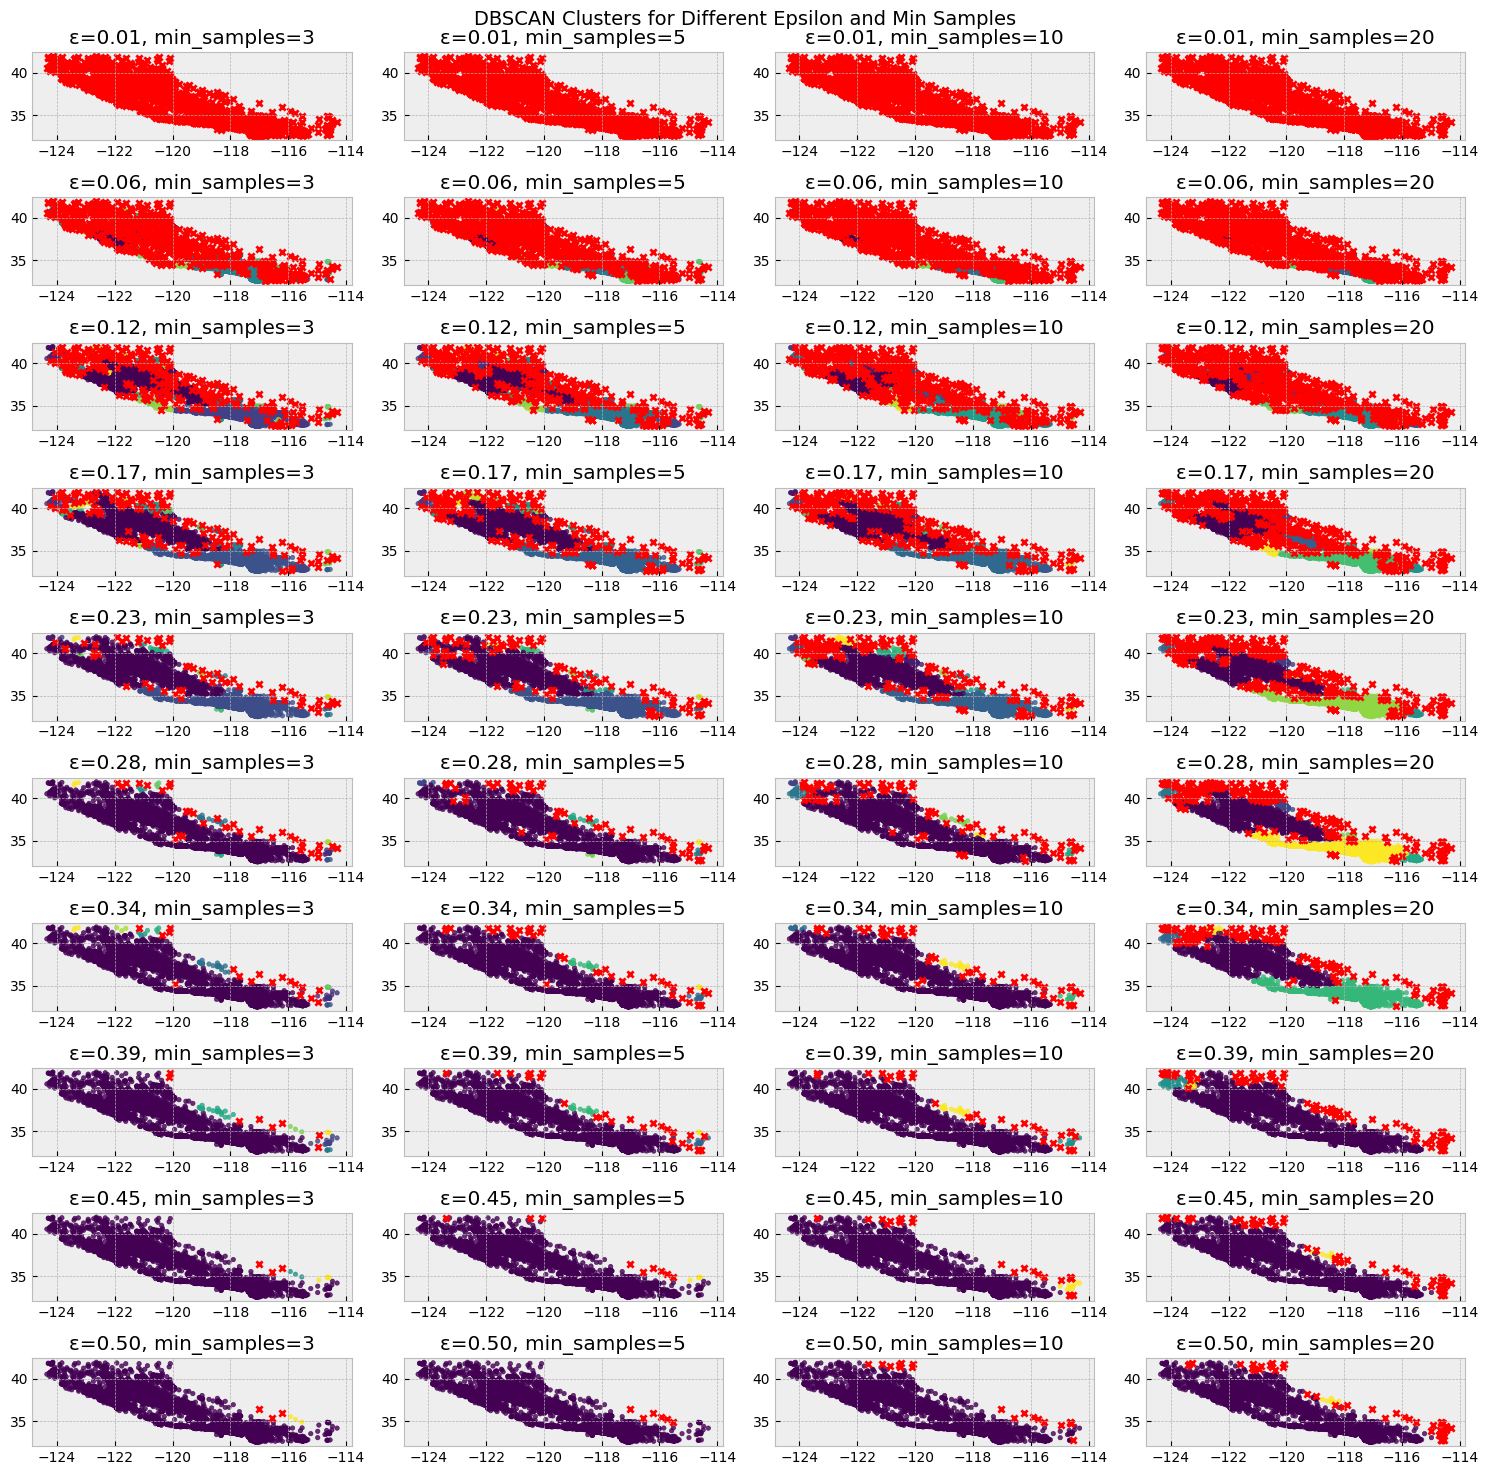

In [24]:
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 15))
fig.suptitle("DBSCAN Clusters for Different Epsilon and Min Samples", fontsize=14)

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_housing)

        ax = axes[i, j]
        core_samples_mask = labels != -1  # True for clustered points
        noise_mask = labels == -1  # True for noise points

        # Scatter plot: Clustered points
        ax.scatter(X_housing[core_samples_mask, 1], X_housing[core_samples_mask, 0],
                   c=labels[core_samples_mask], cmap="viridis", s=10, alpha=0.8)

        # Scatter plot: Noise points
        ax.scatter(X_housing[noise_mask, 1], X_housing[noise_mask, 0],
                   c='red', marker='x', s=20, label="Noise")

        ax.set_title(f"ε={eps:.2f}, min_samples={min_samples}")

plt.tight_layout()
plt.show()

#### Explore the above visualizations

1. Which epsilon and min_samples combination(s) do you think is (are) best?
  - epsilon = 0.34, min_samples = 20
2. Support your reasoning.
  - Likely forms well-defined clusters with fewer noise points


### Automatic Extraction of Best Hyperparameters


We are now performing grid search over different values of epsilon and min_points and then automatically extracting the best combination of values based on silhouette score.

### **What Does This Code Do?**
1. **Runs DBSCAN** for each combination of `eps` and `min_samples`.
2. **Records key evaluation metrics**:
   - **Number of clusters formed** (excluding noise).
   - **Number of noise points** (points classified as `-1`).
   - **Silhouette score**
3. **Plots how these values change** as `eps` and `min_samples` vary.

In [25]:
# Function to evaluate DBSCAN parameters
def evaluate_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    # Count number of clusters and noise points
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # Calculate silhouette score if more than one cluster and not all noise
    if n_clusters > 1 and n_noise < len(labels):
        score = silhouette_score(X, labels)
    else:
        score = -1

    return labels, n_clusters, n_noise, score

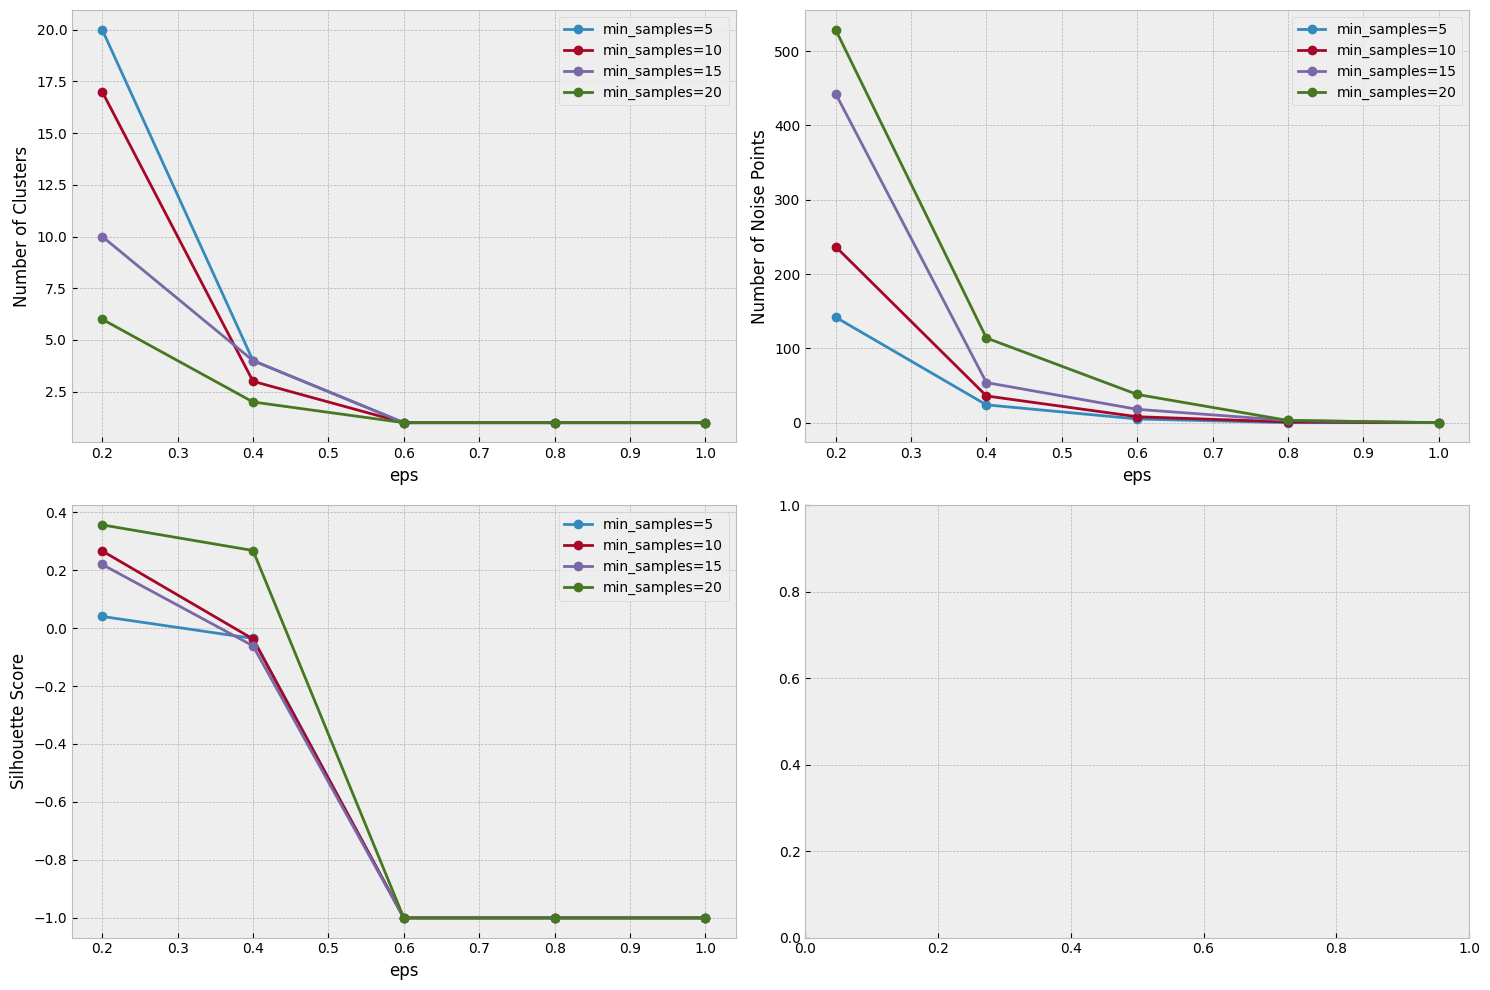

In [26]:
# Grid search over eps and min_samples
eps_range = np.arange(0.2, 1.1, 0.2)
min_samples_range = [5, 10, 15, 20]

results = []
for eps in eps_range:
    for min_samples in min_samples_range:
        labels, n_clusters, n_noise, score = evaluate_dbscan(X_housing, eps, min_samples)
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': score
        })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Plot parameter evaluation results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Number of clusters
for i, min_samples in enumerate(min_samples_range):
    mask = results_df['min_samples'] == min_samples
    axes[0, 0].plot(results_df[mask]['eps'],
                    results_df[mask]['n_clusters'],
                    'o-', label=f'min_samples={min_samples}')
axes[0, 0].set_xlabel('eps')
axes[0, 0].set_ylabel('Number of Clusters')
axes[0, 0].legend()

# Number of noise points
for i, min_samples in enumerate(min_samples_range):
    mask = results_df['min_samples'] == min_samples
    axes[0, 1].plot(results_df[mask]['eps'],
                    results_df[mask]['n_noise'],
                    'o-', label=f'min_samples={min_samples}')
axes[0, 1].set_xlabel('eps')
axes[0, 1].set_ylabel('Number of Noise Points')
axes[0, 1].legend()

# Silhouette score
for i, min_samples in enumerate(min_samples_range):
    mask = results_df['min_samples'] == min_samples
    axes[1, 0].plot(results_df[mask]['eps'],
                    results_df[mask]['silhouette'],
                    'o-', label=f'min_samples={min_samples}')
axes[1, 0].set_xlabel('eps')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].legend()

plt.tight_layout()
plt.show()


## **How to Interpret the Plots**
### **Top Left: Number of Clusters vs. Epsilon**
- **More clusters at smaller `eps`** → DBSCAN identifies **tighter, denser groups**.
- **As `eps` increases, clusters merge** → Fewer, larger clusters form.
- **If `eps` is too large**, DBSCAN may detect **only one large cluster**, losing meaningful structure.

**What to Look For:**  
- An **appropriate `eps`** should form a reasonable **number of clusters**, not too many or too few.

---

### **Top Right: Number of Noise Points vs. Epsilon**
- **High noise at small `eps`** → Many points are **too isolated** to be assigned to clusters.
- **Noise decreases as `eps` increases** → More points are absorbed into clusters.
- **If `eps` is too large**, almost **all points belong to one big cluster**, meaning noise approaches **zero**.

**What to Look For:**  
- **Balance between clusters and noise.**  
- Too much noise? **Increase `eps`** or **reduce `min_samples`**.  
- Too little noise? **Decrease `eps`** to maintain meaningful clusters.

---

### **Bottom Left: Silhouette Score vs. Epsilon**
- **Silhouette score measures clustering quality**:
  - **High silhouette score** → Well-separated clusters.
  - **Low silhouette score** → Overlapping or poorly defined clusters.
- **At small `eps`, scores may be negative** → Too many small clusters or noise.
- **At large `eps`, score drops to -1** → Everything is merged into one cluster.

**What to Look For:**  
- The **best clustering** occurs at the **highest positive silhouette score**.
- **Avoid high `eps` values where the silhouette score collapses.**

## Choosing the "Best" DBSCAN Hyperparameters

In this step, we are **automatically selecting the best hyperparameters** `(eps, min_samples)` based on **silhouette score**.

### **How Does This Work?**
- **Silhouette score** measures how well-separated clusters are:
  - **Higher score** → Clusters are well-separated.
  - **Lower score** → Overlapping or poorly-defined clusters.
- We extract the `(eps, min_samples)` combination with **the highest silhouette score**:

`  best_result = results_df.loc[results_df['silhouette'].idxmax()]`

Optimal Epsilon Extracted: 0.2
Optimal Minimum Samples Extracted: 20


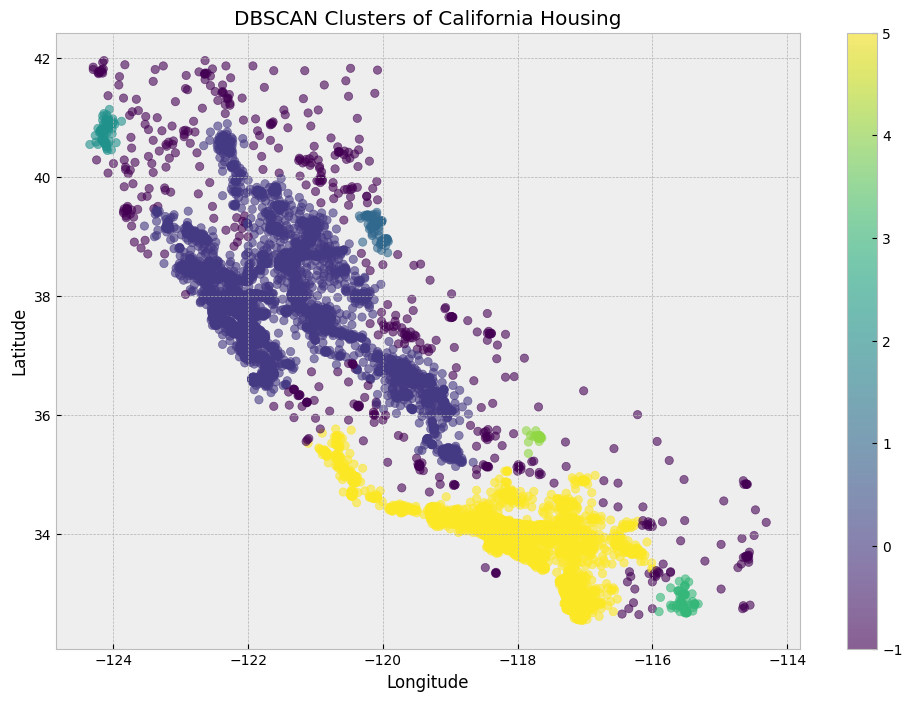

In [27]:
# Apply DBSCAN with optimal parameters
best_result = results_df.loc[results_df['silhouette'].idxmax()]
optimal_eps = best_result['eps']
optimal_min_samples = int(best_result['min_samples'])

print(f'Optimal Epsilon Extracted: {optimal_eps}')
print(f'Optimal Minimum Samples Extracted: {optimal_min_samples}')

final_dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
cluster_labels = final_dbscan.fit_predict(X_housing)

# Visualize final clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_housing[:, 1], X_housing[:, 0],
                     c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clusters of California Housing')
plt.colorbar(scatter)
plt.show()



## Comparing Human vs. Programmatic Best Silhouette Scores

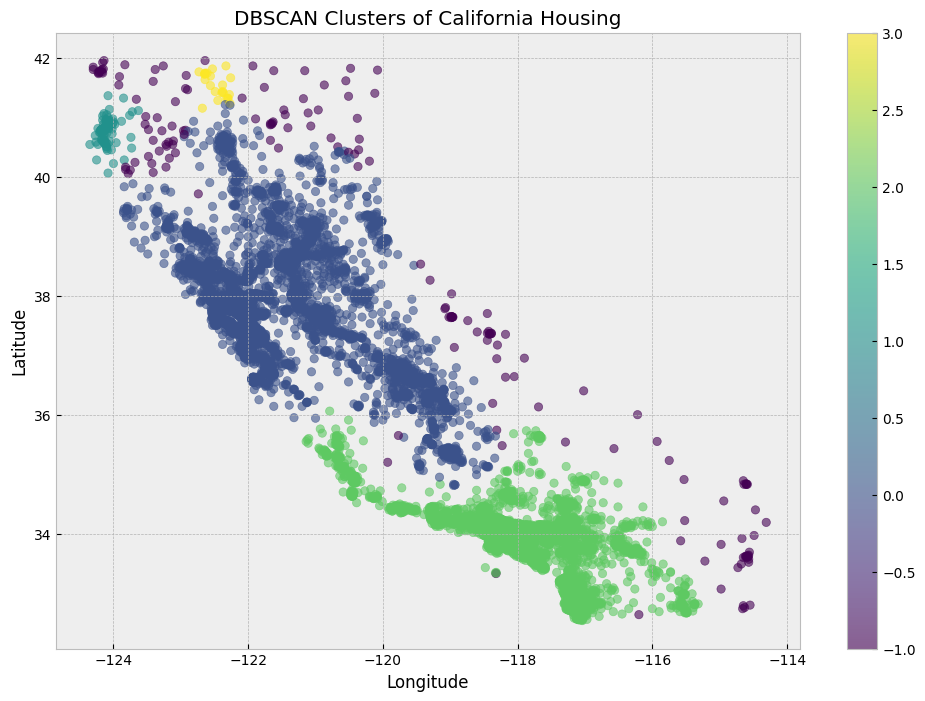

In [33]:
# Apply DBSCAN with your parameters

your_dbscan = DBSCAN(eps=0.34, min_samples=20)
cluster_labels = your_dbscan.fit_predict(X_housing)

# Visualize your clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_housing[:, 1], X_housing[:, 0],
                     c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clusters of California Housing')
plt.colorbar(scatter)
plt.show()